# Introduction

Input data about Amazon Stock and descriptions can be found [here](https://www.kaggle.com/prasoonkottarathil/amazon-stock-price-20142019)<br>
This project is going to explore and forecast the timeseries about Amazon Stock by using ARIMA model.

# EDA
First I will import basic explore libraries. Next I will read the file into Jupyter and start my exploration.

In [24]:
# import library
from dateutil.parser import  parse
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (15,5), 'figure.dpi': 120})


In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# import as dataframe
df = pd.read_csv("https://raw.githubusercontent.com/xiaolancara/product_studio/master/AMAZON%20_stock.csv",parse_dates=['Date'])                                                                                                   
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,398.799988,399.359985,394.019989,397.970001,397.970001,2137800
1,2014-01-03,398.290009,402.709991,396.220001,396.440002,396.440002,2210200
2,2014-01-06,395.850006,397.000000,388.420013,393.630005,393.630005,3170600
3,2014-01-07,395.040009,398.470001,394.290009,398.029999,398.029999,1916000
4,2014-01-08,398.470001,403.000000,396.040009,401.920013,401.920013,2316500


For this project, I am only going to explore the 'Close' Stock information.<br>

In [27]:
# extract only the Close attribute.
df = df[['Date','Close']]
# set Date as index, then the value only has One: Close Stock
df.set_index('Date',inplace=True)
df

,Close
Date,
2014-01-02,397.970001
2014-01-03,396.440002
2014-01-06,393.630005
2014-01-07,398.029999
2014-01-08,401.920013
...,...
2019-01-25,1670.569946
2019-01-28,1637.890015
2019-01-29,1593.880005


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1279 entries, 2014-01-02 to 2019-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1279 non-null   float64
dtypes: float64(1)
memory usage: 20.0 KB


In [29]:
# row = df.index.get_loc('2017-01-03')
# df = df[row:]

In [30]:
# check if dataset includes null data
df.isnull().sum()

Close    0
dtype: int64

In [31]:
df

,Close
Date,
2014-01-02,397.970001
2014-01-03,396.440002
2014-01-06,393.630005
2014-01-07,398.029999
2014-01-08,401.920013
...,...
2019-01-25,1670.569946
2019-01-28,1637.890015
2019-01-29,1593.880005


I will first plot the data see how it distributes.

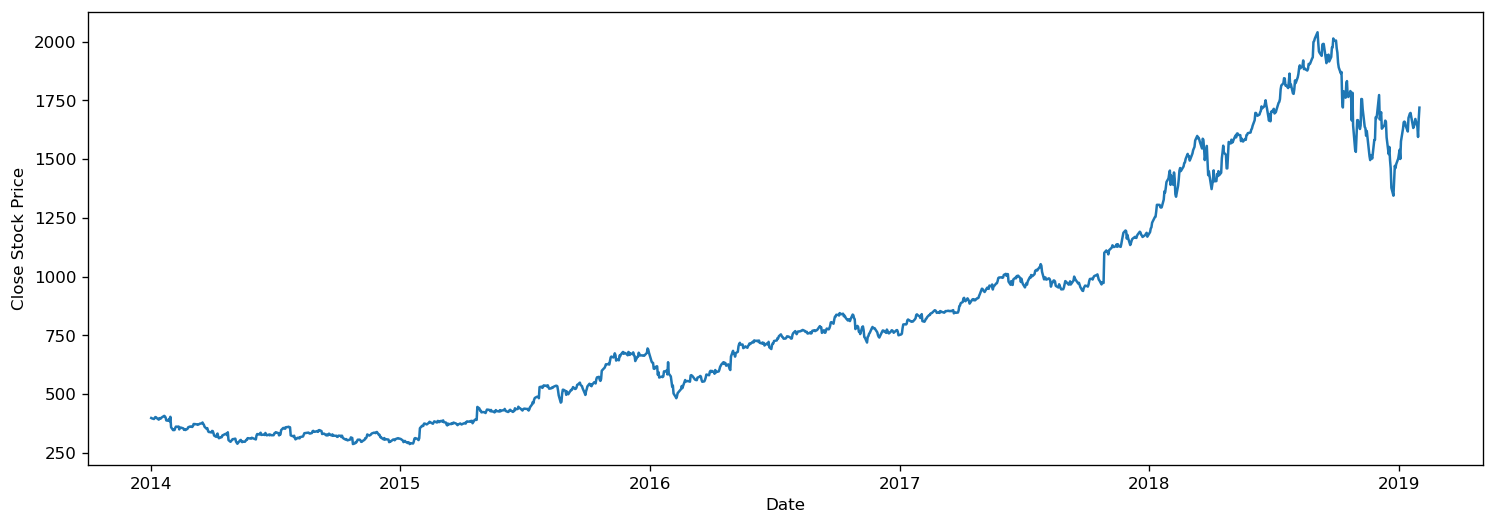

In [32]:
# plot graph
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.plot(df)

From the above plot, we can tell the stock has a abviously trend. I will plot the trend as below to check again.

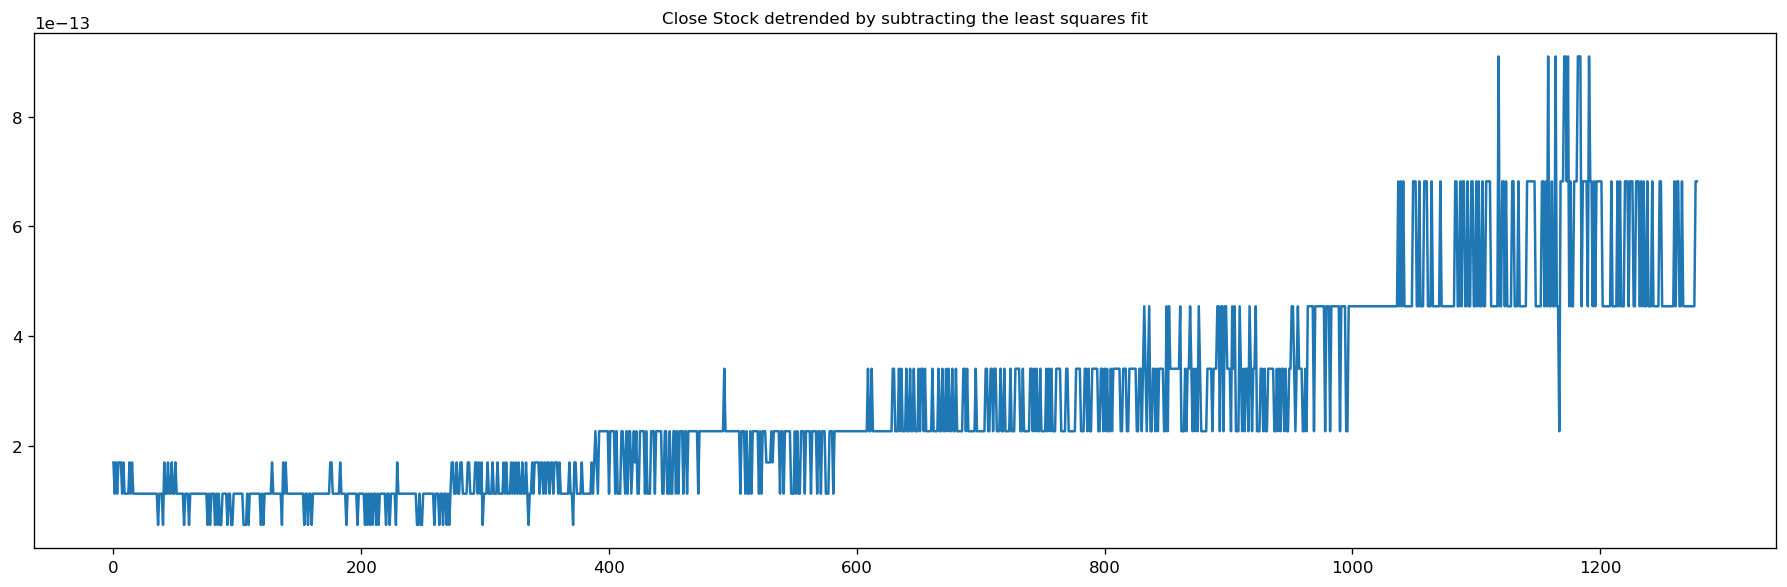

In [33]:
from scipy import signal

detrended = signal.detrend(df.values)
plt.title('Close Stock detrended by subtracting the least squares fit', fontsize=10)
plt.plot(detrended)
plt.tight_layout()
plt.show()

From the trend plot, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data

In [34]:
#Determine rolling statistics
rolmean = df.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df.rolling(window=12).std()
print(rolmean,rolstd)

                  Close
Date                   
2014-01-02          NaN
2014-01-03          NaN
2014-01-06          NaN
2014-01-07          NaN
2014-01-08          NaN
...                 ...
2019-01-25  1659.905009
2019-01-28  1658.110840
2019-01-29  1652.915843
2019-01-30  1655.405009
2019-01-31  1663.865011

[1279 rows x 1 columns]                 Close
Date                 
2014-01-02        NaN
2014-01-03        NaN
2014-01-06        NaN
2014-01-07        NaN
2014-01-08        NaN
...               ...
2019-01-25  24.727676
2019-01-28  25.533995
2019-01-29  31.579629
2019-01-30  31.694183
2019-01-31  34.034827

[1279 rows x 1 columns]


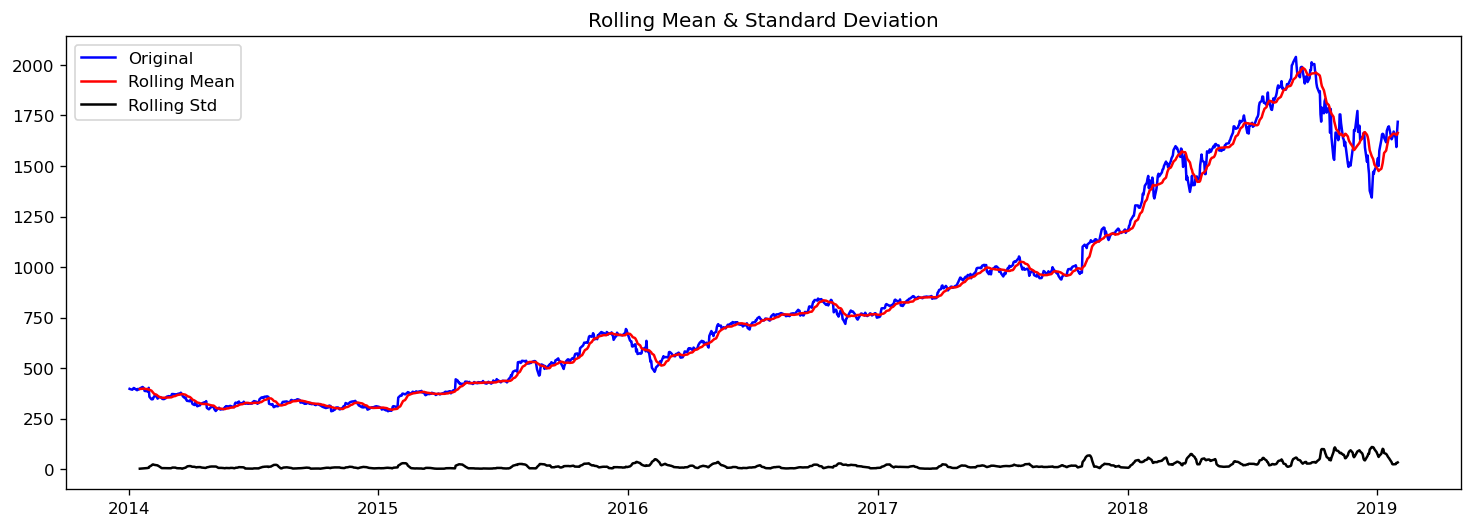

In [35]:
#Plot rolling statistics
def Plot_rolling_statistics(dataset):    
    orig = plt.plot(dataset, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
Plot_rolling_statistics(df)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test and KPSS test.

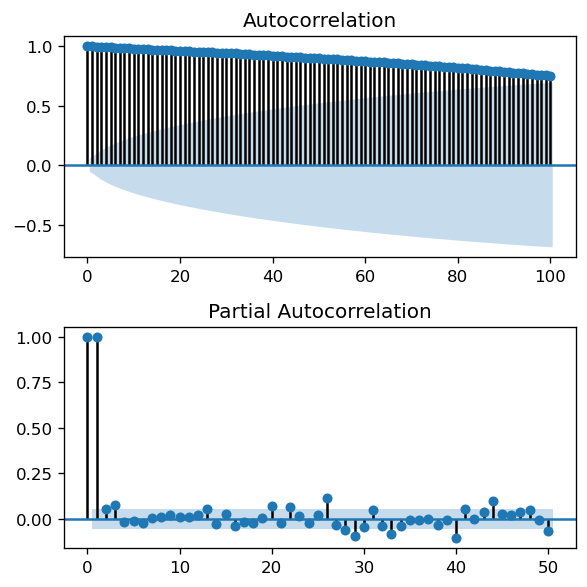

In [36]:
#ACF & PACF plots
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# Draw Plot
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close'],lags=100,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close'],lags=50,ax=ax2)

plt.tight_layout()
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller, kpss

def ADF_test(atrribute):
    # ADF Test
    result = adfuller(atrribute.values, autolag='AIC')
    print(f'ADF Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
def KPSS_test(atrribute):
    # KPSS Test
    result = kpss(atrribute.values, regression='c')
    print('\nKPSS Test Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

ADF_test(df.Close)
KPSS_test(df.Close)

ADF Test Statistic: 0.21508832158238445
p-value: 0.9730952676708994
Critial Values:
   1%, -3.435571295403709
Critial Values:
   5%, -2.863845736356174
Critial Values:
   10%, -2.567997600196822

KPSS Test Statistic: 4.868146
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


For a Time series to be stationary<br>
Its ADCF test should have:<br>
p-value to be low (according to the null hypothesis: It is NOT stationary)<br>
The Test Statistics should higher than the critical values at 1%,5%,10% confidence intervals 
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also the Test Statistics is higher than all critical values.<br>


In Contrast, the KPSS test should  have:<br>
according to the null hypothesis: It is stationary
The Test Statistics should lower than the critical values at 1%,2.5%,5%,10% confidence intervals<br>
From the above KPSS test result, we see that the Test Statistics is higher than all critical values. thus, we reject the null hypothesis<br>


Hence, we can safely say that our Time Series at the moment is not stationary.


# Data Transformation to achieve Stationarity 
There are a couple of ways to achieve stationarity through data transformation like taking  order difference, log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with 1st order difference transformations. Our objective is to remove the trend component after taking 1st order difference would say that our data transformation did a good job.

# 1st Order Difference

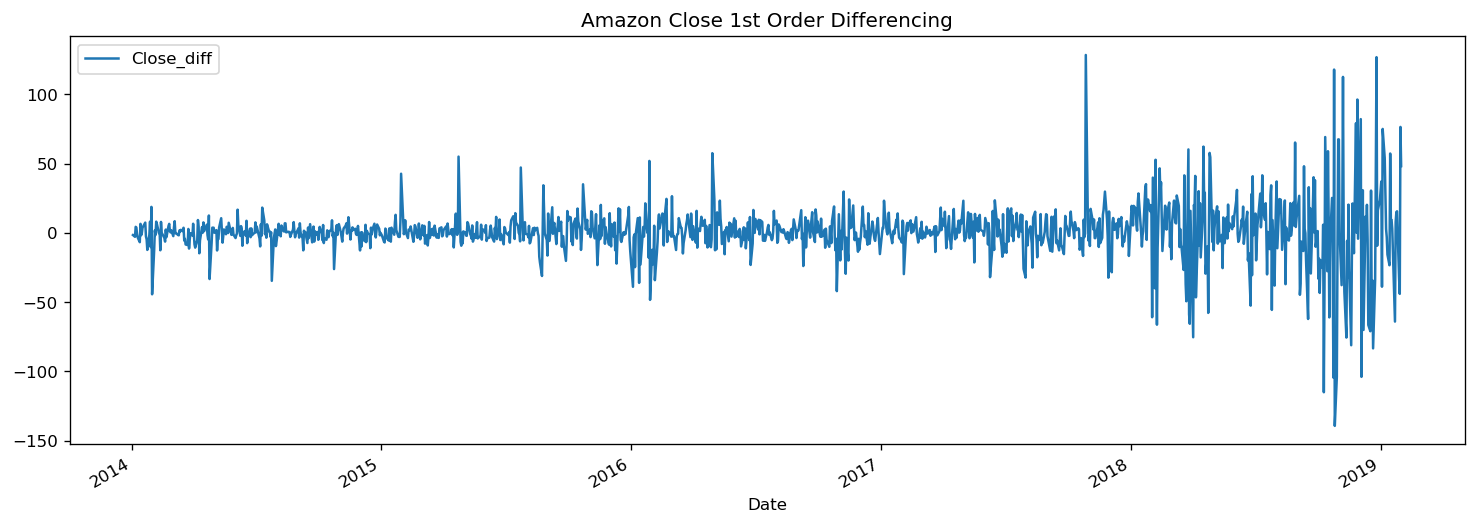

In [38]:
# first difference
D_df = df.diff().dropna()   
D_df.columns = [u'Close_diff']

# Plot difference
D_df.plot() 
plt.title("Amazon Close 1st Order Differencing")  
plt.show() 

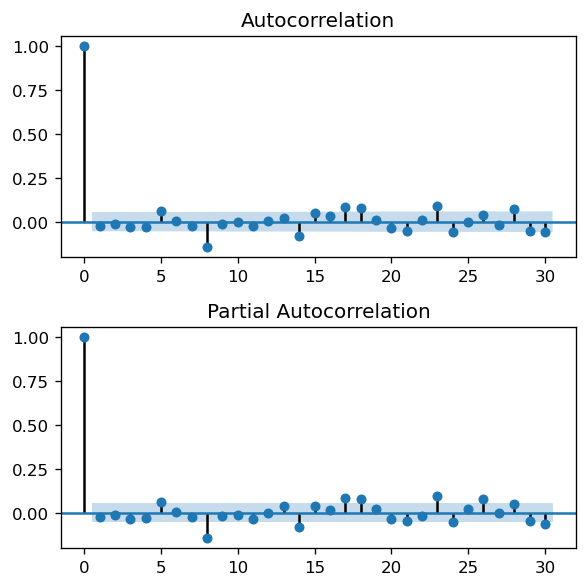

In [39]:
# Draw Plot
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(D_df,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(D_df,lags=30,ax=ax2)

plt.tight_layout()
plt.show()

It can be seen from the above first order difference autocorrelation diagram that the tend is stable.

In [40]:
ADF_test(D_df)

ADF Test Statistic: -6.908184094912584
p-value: 1.2317154434923999e-09
Critial Values:
   1%, -3.4355754676859886
Critial Values:
   5%, -2.8638475772391665
Critial Values:
   10%, -2.5679985805677017


We observe that the Time Series is stationary since p-value has decreased from 0.88 to 0.000000005.
Test Statistic value is much lower to the Critical values.
This says that our current 1st order difference transformation is better than the previous. 

In [41]:
# After difference, use the white noise to test the data 
from statsmodels.tsa import stattools 

LjungBox=stattools.q_stat(stattools.acf(D_df)[1:12],len(D_df))
LjungBox[1][-1]

0.00010939750492215458

We can see the P-value = 0.0001702 > 5% Critial Values, so the null hypothesis cannot be rejected. In other words, the timeseries after 1st order difference is a stationary white noise timeseries.

# Build the ARIMA Model

After the first difference, the data sequence becomes a stationary white noise sequence, so the AR(1) model can be preliminarily judged.

In [42]:
from statsmodels.tsa.arima_model import ARIMA 
# 1,1,2 ARIMA Model
model=ARIMA(df,order=(1,1,2)) 
result=model.fit(disp=0) 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1278
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5604.121
Method:                       css-mle   S.D. of innovations             19.417
Date:                Mon, 09 Nov 2020   AIC                          11218.242
Time:                        00:07:22   BIC                          11244.008
Sample:                             1   HQIC                         11227.918
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0250      0.448      2.289      0.022       0.147       1.903
ar.L1.D.Close     0.8236      0.095      8.648      0.000       0.637       1.010
ma.L1.D.Close    -0.8485      0.099     -8.591      0.000      -1.042      -0.655
ma.L2.D.Close    -0.0062      0.030     -0.209      0.835      -0.064       0.052
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2142           +0.0000j            1.2142            0.0000
MA.1            1.1686           +0.0000j            1.1686            0.0000
MA.2         -138.1814           +0.0000j          138.1814            0.5000
-----------------------------------------------------------------------------
"""

In [43]:
result.conf_int()#diagnose Model

,0,1
const,0.147298,1.902758
ar.L1.D.Close,0.636904,1.010216
ma.L1.D.Close,-1.042043,-0.654912
ma.L2.D.Close,-0.064372,0.051987


The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.


The confidence interval of the coefficients contained zero, so it could not be said that all the coefficients were significant at the 5% confidence level, thus overturning the AR(1) model.

So, let’s rebuild the model without the MA2 term.

# Model modification

In [44]:
# 3,1,4 ARIMA Model
model=ARIMA(df,order=(3,1,4)) 
result=model.fit(disp=0) 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1278
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -5593.658
Method:                       css-mle   S.D. of innovations             19.255
Date:                Mon, 09 Nov 2020   AIC                          11205.316
Time:                        00:07:24   BIC                          11251.693
Sample:                             1   HQIC                         11222.731
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0335      0.516      2.004      0.045       0.023       2.044
ar.L1.D.Close    -0.7272      0.043    -16.727      0.000      -0.812      -0.642
ar.L2.D.Close    -0.6888      0.060    -11.475      0.000      -0.806      -0.571
ar.L3.D.Close    -0.8831      0.048    -18.571      0.000      -0.976      -0.790
ma.L1.D.Close     0.7092      0.051     13.818      0.000       0.609       0.810
ma.L2.D.Close     0.6752      0.066     10.218      0.000       0.546       0.805
ma.L3.D.Close     0.8540      0.059     14.580      0.000       0.739       0.969
ma.L4.D.Close    -0.0794      0.032     -2.519      0.012      -0.141      -0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0378           -0.0000j            1.0378           -0.5000
AR.2            0.1290           -1.0366j            1.0446           -0.2303
AR.3            0.1290           +1.0366j            1.0446            0.2303
MA.1           -1.0144           -0.0000j            1.0144           -0.5000
MA.2            0.1021           -1.0311j            1.0361           -0.2343
MA.3            0.1021           +1.0311j            1.0361            0.2343
MA.4           11.5684           -0.0000j           11.5684           -0.0000
-----------------------------------------------------------------------------
"""

In [45]:
result.conf_int()#diagnose Model

,0,1
const,0.022512,2.044390
ar.L1.D.Close,-0.812368,-0.641956
ar.L2.D.Close,-0.806389,-0.571113
ar.L3.D.Close,-0.976306,-0.789901
ma.L1.D.Close,0.608606,0.809788
ma.L2.D.Close,0.545712,0.804752
ma.L3.D.Close,0.739163,0.968747
ma.L4.D.Close,-0.141133,-0.017621


The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).


To make the model more accurate, we further use confint () function calculation model of the coefficient of interval, the results above, it can be seen that, in addition to intercept items, all of the confidence interval coefficients does not contain zero, so we can say under the confidence level of 5%, all the coefficients are significant, as the model to test.

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

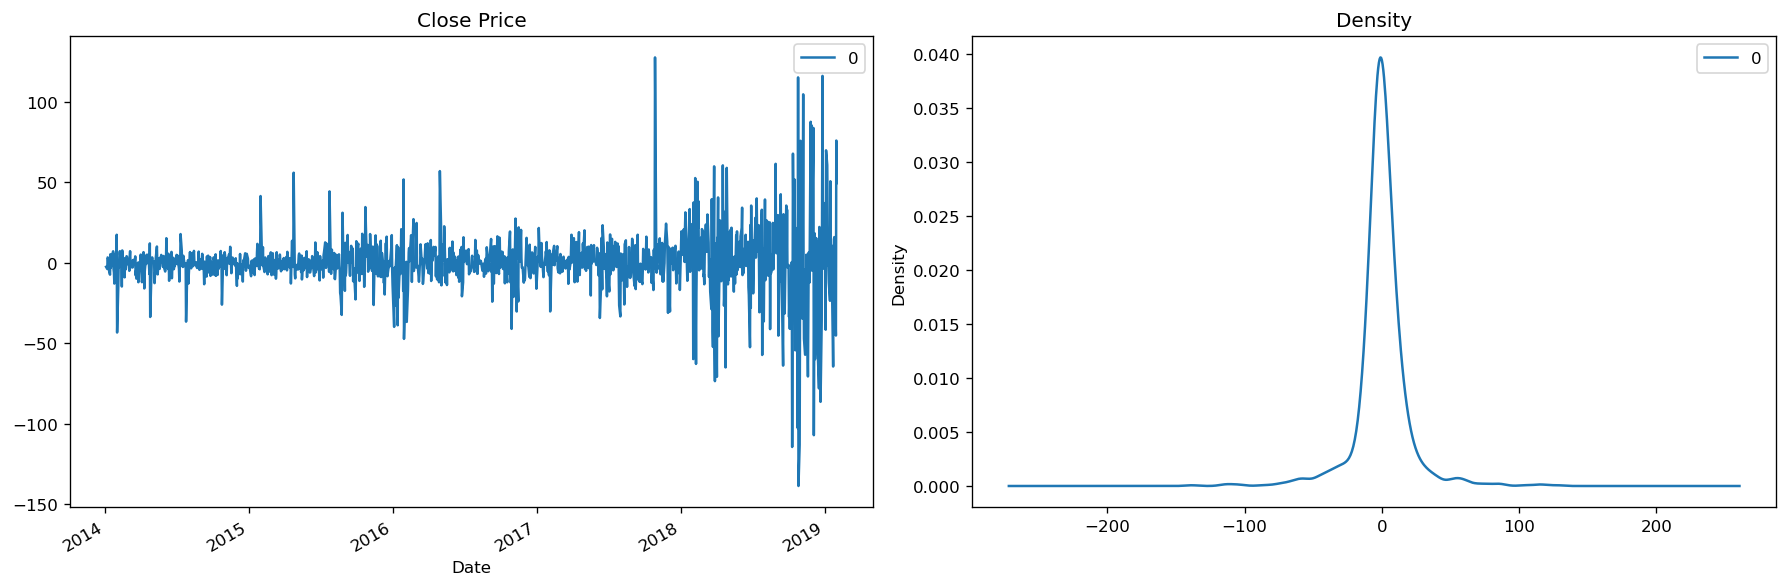

In [46]:
# Plot residual errors
residual  = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residual .plot(title="Close Price", ax=ax[0])
residual .plot(kind='kde', title='Density', ax=ax[1])

plt.tight_layout()
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

# Predict

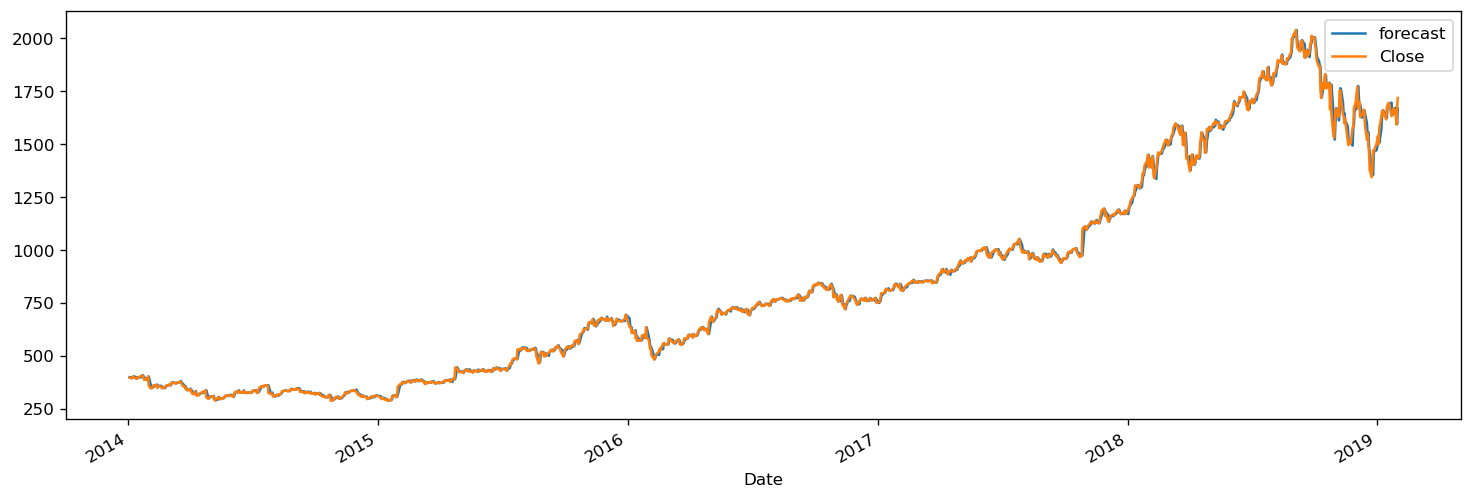

In [47]:
# Actual vs Fitted
result.plot_predict(dynamic=False)
plt.show()

# Out-of-Time cross-validation

In [48]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df[:'2018-11-01']
test = df['2018-11-01':]

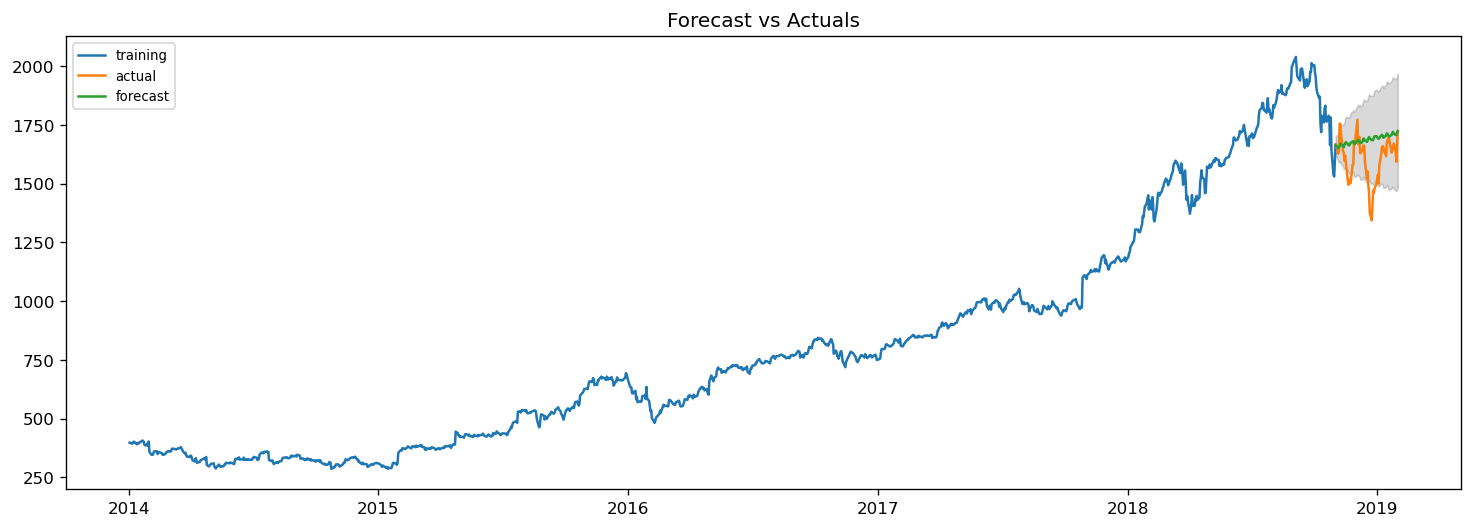

In [49]:
# Build Model
  
model = ARIMA(train, order=(3, 1, 4))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(61, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# prepare data
df.dropna(inplace=True)
X = df.values
X = X.astype('float')
train_size = df.index.get_loc('2018-11-01')
print(train_size)
#train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
#predict
predictions = list() 
for i in range(len(test)):
    model = ARIMA(history, order=(3,1,4))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

1218
>Predicted=1593.046, Expected=1666
>Predicted=1663.321, Expected=1666
>Predicted=1662.525, Expected=1628
>Predicted=1619.300, Expected=1643
>Predicted=1642.444, Expected=1755
>Predicted=1758.553, Expected=1755
>Predicted=1749.023, Expected=1712
>Predicted=1696.109, Expected=1637
>Predicted=1642.665, Expected=1631
>Predicted=1655.909, Expected=1599
>Predicted=1602.937, Expected=1619
>Predicted=1604.928, Expected=1593
>Predicted=1586.497, Expected=1512
>Predicted=1528.227, Expected=1495
>Predicted=1506.456, Expected=1517
>Predicted=1513.475, Expected=1502
>Predicted=1491.929, Expected=1581
>Predicted=1582.337, Expected=1581
>Predicted=1578.176, Expected=1678
>Predicted=1677.179, Expected=1674
>Predicted=1666.647, Expected=1690
>Predicted=1688.858, Expected=1772
>Predicted=1770.249, Expected=1668
>Predicted=1675.474, Expected=1699
>Predicted=1691.432, Expected=1629
>Predicted=1631.157, Expected=1641
>Predicted=1649.352, Expected=1643
>Predicted=1642.159, Expected=1664
>Predicted=1661

# Conclusion

The fitting effect of the data is ok, and the difference between the real value and the predicted value is not big.
Therefore, the model has a good effect on data prediction.

# Reference

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.machinelearningplus.com/time-series/time-series-analysis-python/

https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima

https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/